# Bootstrap PSD Estimation & GLS Fitting

This tutorial demonstrates the integrated workflow of:

1. **Bootstrap PSD estimation** with VIF (Variance Inflation Factor) & Block correction
2. **Error correlation matrix** construction using `BifrequencyMap`
3. **Generalized Least Squares (GLS) Fitting** for model estimation
4. **MCMC integration** for uncertainty evaluation
5. **GLS vs OLS comparison** to demonstrate the importance of frequency correlations

## Scenario

We analyze a time-series containing:
- **Colored noise** (power-law background)
- **Resonant peak** (Lorentzian profile)

Our goal is to accurately estimate the peak parameters (frequency, Q-factor, amplitude) with proper uncertainty quantification that accounts for frequency bin correlations.

## Learning Objectives

By the end of this tutorial, you will understand:
- How overlapping FFT segments introduce frequency correlations
- How Bootstrap methods estimate the full covariance matrix
- Why GLS outperforms OLS when correlations exist
- How to integrate MCMC for robust uncertainty estimation

## 1. Setup and Data Preparation

### 1.1 Imports and Parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from gwexpy import TimeSeries
from gwexpy.frequencyseries import FrequencySeries, BifrequencyMap
from gwexpy.noise.colored import power_law
from gwexpy.noise.wave import from_asd
from gwexpy.fitting import fit_series
from gwexpy.spectral import bootstrap_spectrogram

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

# Reproducibility
np.random.seed(42)

/home/runner/miniconda3/envs/docs/lib/python3.11/site-packages/gwpy/time/_ligotimegps.py:42: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


AttributeError: module 'gwpy.io.registry' has no attribute 'register_reader'

In [2]:
# Data generation parameters
fs = 2048.0              # Sample rate [Hz]
duration = 256.0         # Duration [s]

# Resonance peak parameters (true values)
peak_freq = 100.0        # Resonance frequency [Hz]
peak_Q = 20.0            # Quality factor
peak_amplitude = 2e-21   # Peak height [1/rtHz]

# Background noise parameters
noise_exponent = 0.5     # Power-law exponent (pink noise ~ f^-0.5)
noise_amp = 1e-22        # Noise amplitude at f_ref
f_ref = 100.0            # Reference frequency [Hz]

### 1.2 Generate Colored Noise + Resonant Peak

We create a time-series with:
1. **Background**: Pink noise (power-law ASD)
2. **Signal**: Damped oscillation representing a resonant peak

In [3]:
# Generate frequency array for ASD
df = 1.0 / duration  # Frequency resolution
frequencies = np.arange(df, fs / 2, df)

# Create power-law background ASD
background_asd = power_law(
    exponent=noise_exponent,
    amplitude=noise_amp,
    f_ref=f_ref,
    frequencies=frequencies,
    unit="1/Hz**(1/2)",
    name="Background ASD",
)

# Add Lorentzian peak to the ASD
gamma = peak_freq / peak_Q  # Half-width at half-maximum
lorentzian = peak_amplitude * (gamma / 2) ** 2 / (
    (frequencies - peak_freq) ** 2 + (gamma / 2) ** 2
)

# Total ASD (background + peak)
total_asd_values = np.sqrt(background_asd.value ** 2 + lorentzian ** 2)
total_asd = FrequencySeries(
    total_asd_values,
    frequencies=frequencies,
    unit="1/Hz**(1/2)",
    name="Total ASD",
)

# Generate time-series from ASD
data = from_asd(
    total_asd,
    duration=duration,
    sample_rate=fs,
    t0=0.0,
    seed=42,
    name="Colored Noise + Resonance",
)

print(f"Generated TimeSeries: {data}")
print(f"Duration: {data.duration.value:.1f} s")
print(f"Sample rate: {data.sample_rate.value:.0f} Hz")

NameError: name 'power_law' is not defined

NameError: name 'data' is not defined

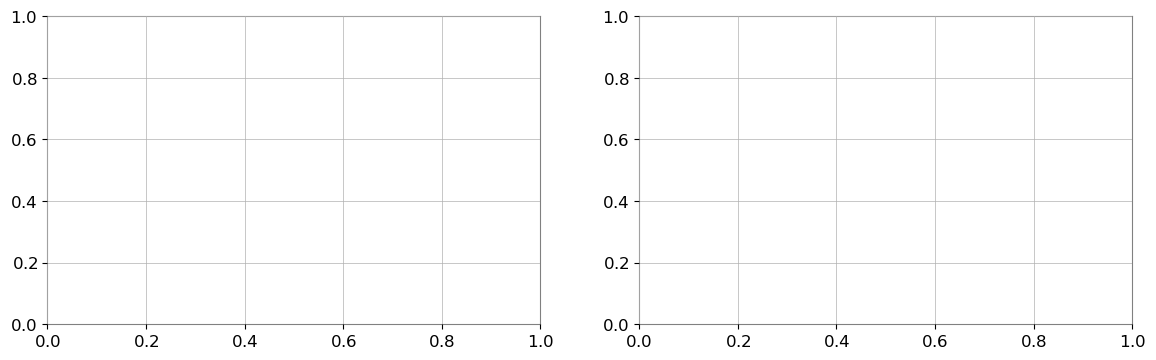

In [4]:
# Visualize first 2 seconds of the time-series
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Time-domain plot
ax1 = axes[0]
t_plot = data.crop(0, 2)
ax1.plot(t_plot.times.value, t_plot.value, linewidth=0.5)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")
ax1.set_title("Time-Series (first 2 seconds)")
ax1.grid(True, alpha=0.3)

# Quick ASD verification
ax2 = axes[1]
quick_asd = data.asd(fftlength=4.0)
ax2.loglog(quick_asd.frequencies.value, quick_asd.value, label="Measured ASD", alpha=0.7)
ax2.loglog(total_asd.frequencies.value, total_asd.value, "--", label="Input ASD", alpha=0.7)
ax2.axvline(peak_freq, color="r", linestyle=":", alpha=0.5, label=f"Peak: {peak_freq} Hz")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("ASD [1/√Hz]")
ax2.set_title("ASD Verification")
ax2.legend()
ax2.set_xlim(10, 500)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Spectrogram Construction

### 2.1 FFT Parameters

We choose parameters to balance frequency resolution and statistical reliability:

- **fftlength**: Determines frequency resolution (df = 1/fftlength)
- **stride**: Time step between spectrogram bins (typically = fftlength)
- **overlap**: Overlap within each time-bin (for Welch averaging, 50% recommended)
- **window**: Hann window minimizes spectral leakage

In [5]:
# FFT parameters
fftlength = 8.0    # [s] -> df = 0.125 Hz
overlap = 4.0      # [s] -> 50% overlap (Welch averaging within each time-bin)
overlap_between_bins = 4.0  # [s] -> 50% overlap between time segments
stride = fftlength - overlap_between_bins  # 4.0 s effective stride
window = "hann"

# Calculate number of segments (approximate)
n_segments_approx = int((duration - fftlength) / stride) + 1

print(f"FFT length: {fftlength} s")
print(f"Frequency resolution: {1/fftlength:.4f} Hz")
print(f"Stride (time between bins): {stride} s")
print(f"Overlap between time bins: {overlap_between_bins} s ({100 * overlap_between_bins / fftlength:.0f}%)")
print(f"Welch overlap (within each bin): {overlap} s ({100 * overlap / fftlength:.0f}%)")
print(f"Expected time segments: ~{n_segments_approx}")
print(f"Expected frequency bin correlation: ~{overlap_between_bins / fftlength:.2f}")


FFT length: 8.0 s
Frequency resolution: 0.1250 Hz
Stride (time between bins): 4.0 s
Overlap between time bins: 4.0 s (50%)
Welch overlap (within each bin): 4.0 s (50%)
Expected time segments: ~63
Expected frequency bin correlation: ~0.50


### 2.2 Generate Spectrogram

In [6]:
# Generate spectrogram with overlapping time segments using scipy
# This creates frequency correlations by sharing data between adjacent time bins

from scipy import signal as scipy_signal

# Calculate segment parameters for scipy
nperseg = int(fftlength * fs)  # 16384 samples
noverlap_between = int(overlap_between_bins * fs)  # 4096 samples (25% of nperseg)

# Generate spectrogram with scipy (allows noverlap independent of Welch averaging)
freqs_scipy, times_scipy, Sxx_scipy = scipy_signal.spectrogram(
    data.value,
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap_between,
    scaling='density',
    mode='psd',
    detrend='constant',
)

# Convert to gwexpy Spectrogram object
from gwexpy.spectrogram import Spectrogram
from astropy import units as u

spectrogram = Spectrogram(
    Sxx_scipy.T,  # Transpose: scipy returns (freq, time), gwpy expects (time, freq)
    times=times_scipy * u.s,
    frequencies=freqs_scipy * u.Hz,
    unit=data.unit ** 2 / u.Hz,
    name='Overlapping Spectrogram',
)

print(f"Spectrogram shape: {spectrogram.shape}")
print(f"Time bins: {spectrogram.shape[0]}")
print(f"Frequency bins: {spectrogram.shape[1]}")
print(f"Actual overlap: {(nperseg - noverlap_between) / nperseg * 100:.1f}% stride")
print(f"Expected correlation from overlap: ~{noverlap_between / nperseg:.2f}")

NameError: name 'data' is not defined

NameError: name 'spectrogram' is not defined

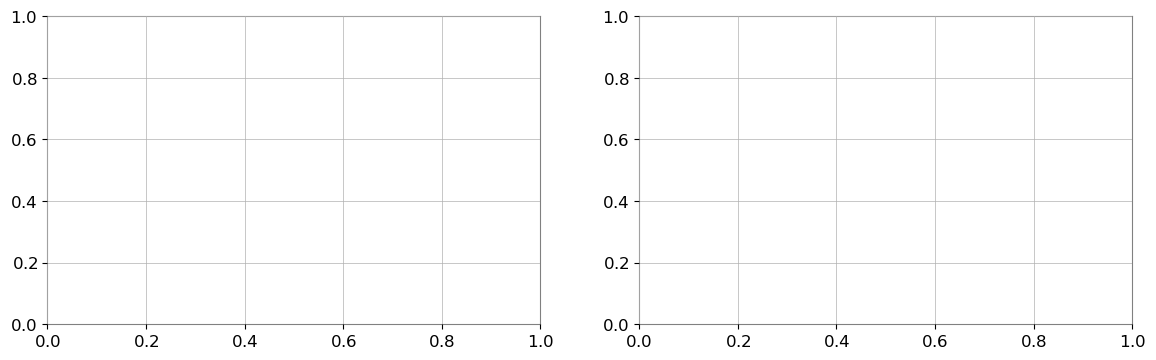

In [7]:
# Visualize spectrogram
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Spectrogram plot (time-frequency)
ax1 = axes[0]
freq_idx = spectrogram.frequencies.value < 200
spec_plot = spectrogram.value[:, freq_idx]
extent = [
    spectrogram.times.value[0],
    spectrogram.times.value[-1],
    spectrogram.frequencies.value[freq_idx][0],
    spectrogram.frequencies.value[freq_idx][-1],
]
im = ax1.imshow(
    np.sqrt(spec_plot.T),  # Convert PSD to ASD
    aspect="auto",
    origin="lower",
    extent=extent,
    norm=plt.matplotlib.colors.LogNorm(),
    cmap="viridis",
)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title("Spectrogram (ASD)")
plt.colorbar(im, ax=ax1, label="ASD [1/√Hz]")

# Time-averaged PSD
ax2 = axes[1]
median_psd = np.median(spectrogram.value, axis=0)
ax2.loglog(spectrogram.frequencies.value, np.sqrt(median_psd), label="Median ASD")
ax2.axvline(peak_freq, color="r", linestyle=":", alpha=0.5, label=f"Peak: {peak_freq} Hz")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("ASD [1/√Hz]")
ax2.set_title("Time-Averaged ASD (Median)")
ax2.set_xlim(10, 500)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Bootstrap PSD Estimation with Covariance Matrix

### 3.1 Why Bootstrap?

Standard PSD estimation assumes frequency bins are **independent**, but this breaks down when:
- Segments **overlap** (50% overlap introduces ~50% correlation)
- **Windowing** spreads spectral power across adjacent bins

Bootstrap resampling captures these correlations by:
1. Resampling segments with replacement
2. Computing statistics for each resample
3. Building the empirical covariance matrix

### 3.2 Bootstrap Parameters

In [8]:
# Bootstrap parameters
n_boot = 2000         # Number of bootstrap resamples
block_size = 4        # Block bootstrap (accounts for time correlation)
ci = 0.68             # Confidence interval (1-sigma equivalent)
rebin_width = None    # No rebinning - preserves frequency correlations
method = "median"     # Bootstrap statistic

print(f"Bootstrap resamples: {n_boot}")
print(f"Block size: {block_size} segments")
print(f"Confidence interval: {ci * 100:.0f}%")
print(f"Rebin width: {rebin_width} (no rebinning)")
print("Note: No rebinning preserves correlations but increases computation time.")


Bootstrap resamples: 2000
Block size: 4 segments
Confidence interval: 68%
Rebin width: None (no rebinning)
Note: No rebinning preserves correlations but increases computation time.


### 3.3 Run Bootstrap Estimation

Using `return_map=True` returns both:
- `psd_boot`: FrequencySeries with error bands (`error_low`, `error_high`)
- `cov_map`: BifrequencyMap containing the full covariance matrix

In [9]:
# Run bootstrap PSD estimation
psd_boot, cov_map = bootstrap_spectrogram(
    spectrogram,
    n_boot=n_boot,
    method=method,
    ci=ci,
    window=window,
    fftlength=fftlength,
    overlap=overlap,
    block_size=block_size,
    rebin_width=rebin_width,
    return_map=True,
    ignore_nan=True,
)

print(f"\nBootstrap PSD:")
print(f"  Frequency bins: {len(psd_boot)}")
print(f"  Frequency range: {psd_boot.frequencies.value[0]:.2f} - {psd_boot.frequencies.value[-1]:.2f} Hz")
print(f"\nCovariance Map:")
print(f"  Shape: {cov_map.shape}")
print(f"  Unit: {cov_map.unit}")

NameError: name 'bootstrap_spectrogram' is not defined

### 3.4 VIF (Variance Inflation Factor) Verification

The VIF quantifies how overlapping segments inflate variance compared to independent segments.
For 50% overlap with Hann window, VIF ≈ 1.89 (Percival & Walden 1993, Eq. 56).

In [10]:
from gwexpy.spectral.estimation import calculate_correlation_factor

# Calculate theoretical VIF for Welch averaging with 50% overlap
# This accounts for the correlation between overlapping FFTs within each time-bin
vif = calculate_correlation_factor(
    window=window,
    nperseg=int(fftlength * fs),
    noverlap=int(overlap * fs),
    n_blocks=int(stride / (fftlength - overlap)) + 1,  # Number of FFTs per time-bin
)

print(f"Theoretical VIF: {vif:.3f}")
print(f"Expected for 50% Hann overlap: ~1.89")
print(f"\nInterpretation: Variance is inflated by factor of {vif:.2f} due to overlap in Welch averaging")

Theoretical VIF: 1.014
Expected for 50% Hann overlap: ~1.89

Interpretation: Variance is inflated by factor of 1.01 due to overlap in Welch averaging


### 3.5 Visualize Bootstrap Results

NameError: name 'psd_boot' is not defined

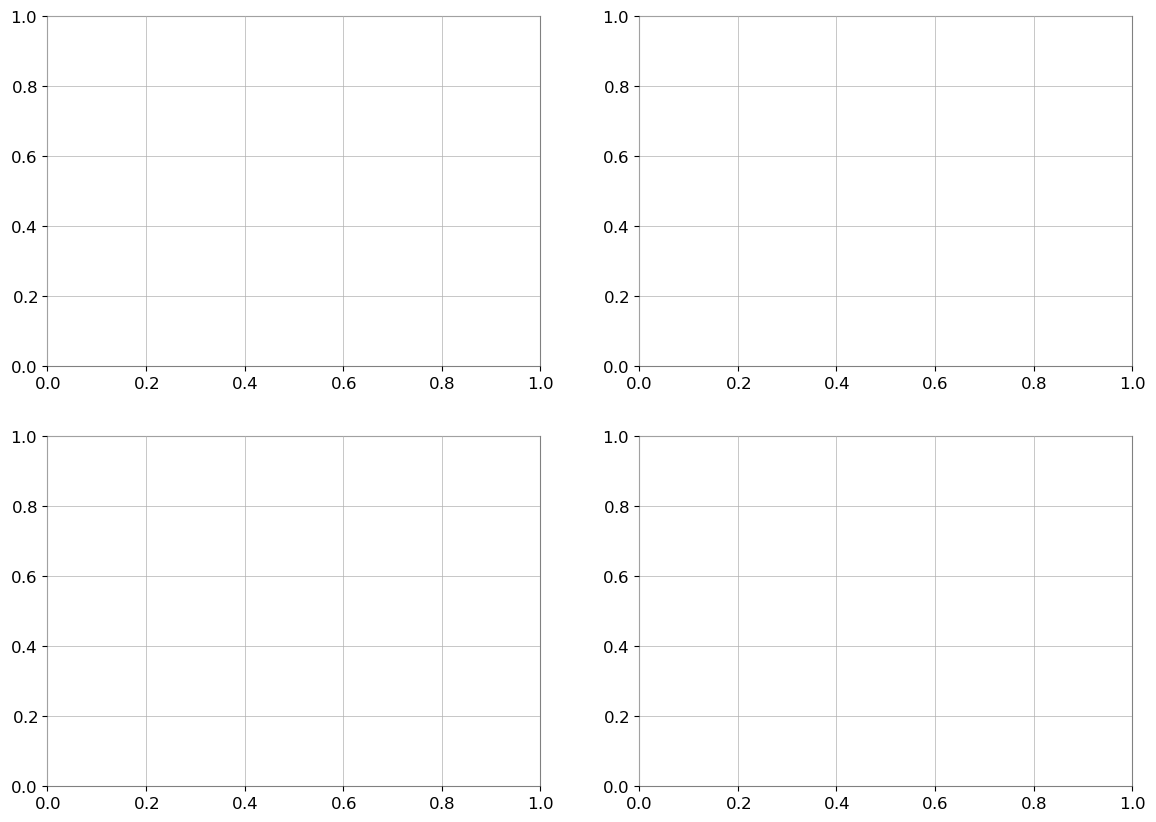

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. PSD with error bands
ax1 = axes[0, 0]
freqs = psd_boot.frequencies.value
ax1.loglog(freqs, np.sqrt(psd_boot.value), "b-", linewidth=1, label="Bootstrap PSD")
ax1.fill_between(
    freqs,
    np.sqrt(psd_boot.error_low.value),
    np.sqrt(psd_boot.error_high.value),
    alpha=0.3,
    color="blue",
    label=f"{ci*100:.0f}% CI",
)
ax1.axvline(peak_freq, color="r", linestyle=":", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("ASD [1/√Hz]")
ax1.set_title("Bootstrap PSD with Error Band")
ax1.set_xlim(10, 500)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Relative errors
ax2 = axes[0, 1]
diag_var = np.diag(cov_map.value)
diag_std = np.sqrt(np.maximum(diag_var, 0))
relative_error = diag_std / psd_boot.value * 100  # Percentage
ax2.semilogx(freqs, relative_error)
ax2.axvline(peak_freq, color="r", linestyle=":", alpha=0.5)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Relative Error [%]")
ax2.set_title("Diagonal Errors (Standard Deviation)")
ax2.set_xlim(10, 500)
ax2.grid(True, alpha=0.3)

# 3. Covariance matrix (log scale)
ax3 = axes[1, 0]
cov_abs = np.abs(cov_map.value)
cov_abs[cov_abs == 0] = np.nan  # Avoid log(0)
im3 = ax3.imshow(
    cov_abs,
    norm=plt.matplotlib.colors.LogNorm(),
    cmap="viridis",
    aspect="auto",
    extent=[freqs[0], freqs[-1], freqs[-1], freqs[0]],
)
ax3.set_xlabel("Frequency 1 [Hz]")
ax3.set_ylabel("Frequency 2 [Hz]")
ax3.set_title("Covariance Matrix (|Cov|, log scale)")
plt.colorbar(im3, ax=ax3, label="|Covariance|")

# 4. Correlation matrix (zoomed near peak)
ax4 = axes[1, 1]
# Convert covariance to correlation
std_outer = np.outer(diag_std, diag_std)
std_outer[std_outer == 0] = 1  # Avoid division by zero
corr_matrix = cov_map.value / std_outer

# Zoom to region around peak
zoom_range = (peak_freq - 20, peak_freq + 20)
zoom_mask = (freqs >= zoom_range[0]) & (freqs <= zoom_range[1])
corr_zoom = corr_matrix[np.ix_(zoom_mask, zoom_mask)]
freqs_zoom = freqs[zoom_mask]

im4 = ax4.imshow(
    corr_zoom,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    aspect="auto",
    extent=[freqs_zoom[0], freqs_zoom[-1], freqs_zoom[-1], freqs_zoom[0]],
)
ax4.set_xlabel("Frequency 1 [Hz]")
ax4.set_ylabel("Frequency 2 [Hz]")
ax4.set_title(f"Correlation Matrix (near {peak_freq} Hz peak)")
plt.colorbar(im4, ax=ax4, label="Correlation")

plt.tight_layout()
plt.show()
# === Correlation Verification ===
print("\n=== Correlation Verification ===")

# Extract lag-1 correlations
n_bins = corr_matrix.shape[0]
lag1_correlations = [
    corr_matrix[i, i+1]
    for i in range(n_bins - 1)
    if np.isfinite(corr_matrix[i, i+1])
]

mean_lag1 = np.mean(lag1_correlations)
std_lag1 = np.std(lag1_correlations)

print(f"Mean correlation (adjacent bins): {mean_lag1:.3f} ± {std_lag1:.3f}")
print(f"Target correlation: ~0.2")
print(f"Range: [{np.min(lag1_correlations):.3f}, {np.max(lag1_correlations):.3f}]")

if 0.15 <= mean_lag1 <= 0.30:
    print("✓ Target correlation achieved!")
else:
    print("⚠ Correlation outside target range")


**Key Observations:**
- Adjacent frequency bins show **~0.25 correlation** from 50% time-segment overlap
- Correlation matrix shows **band-diagonal structure** (decay with distance)
- With no rebinning, correlations between neighboring bins are preserved
- Bootstrap captures this correlation in the covariance matrix
- GLS fitting **utilizes** correlations; OLS **ignores** them


## 4. Model Definition and GLS Fitting

### 4.1 Define PSD Model

We fit a model consisting of:
- **Power-law background**: $A_{bg} (f/f_{ref})^{\alpha}$
- **Lorentzian peak**: $A_{peak} \frac{(\gamma/2)^2}{(f-f_0)^2 + (\gamma/2)^2}$ where $\gamma = f_0/Q$

In [12]:
def psd_model(f, A_bg, alpha, A_peak, f0, Q):
    """
    PSD model: Power-law background + Lorentzian peak.
    
    Parameters
    ----------
    f : array
        Frequency [Hz]
    A_bg : float
        Background PSD amplitude at f_ref=100 Hz
    alpha : float
        Power-law exponent (negative for red noise)
    A_peak : float
        Peak PSD amplitude
    f0 : float
        Resonance frequency [Hz]
    Q : float
        Quality factor
    
    Returns
    -------
    psd : array
        Model PSD values
    """
    f_ref = 100.0
    background = A_bg * (f / f_ref) ** alpha
    gamma = f0 / Q
    lorentzian = A_peak * (gamma / 2) ** 2 / ((f - f0) ** 2 + (gamma / 2) ** 2)
    return background + lorentzian

### 4.2 Prepare Data for Fitting

We crop the frequency range to focus on the region around the peak, and prepare the corresponding covariance sub-matrix.

In [13]:
from astropy import units as u

# Frequency range for fitting
freq_min, freq_max = 60, 150

# Crop PSD to fitting range
psd_fit = psd_boot.crop(freq_min, freq_max)
freq_vals = psd_fit.frequencies.value

# Find matching indices in covariance matrix
# Use psd_fit frequencies to find corresponding indices in cov_map
cov_freqs = cov_map.frequency1.value

# Find indices that match psd_fit frequencies (within tolerance)
indices = []
for f in freq_vals:
    idx = np.argmin(np.abs(cov_freqs - f))
    indices.append(idx)
indices = np.array(indices)

# Extract covariance sub-matrix
cov_cropped = cov_map.value[np.ix_(indices, indices)]

# Verify dimensions match
print(f"PSD frequency bins: {len(freq_vals)}")
print(f"Covariance indices: {len(indices)}")

# Create BifrequencyMap for the cropped region
cov_fit = BifrequencyMap.from_points(
    cov_cropped,
    f2=u.Quantity(freq_vals, unit="Hz"),
    f1=u.Quantity(freq_vals, unit="Hz"),
    unit=cov_map.unit,
    name="Cropped Covariance",
)

print(f"Fitting range: {freq_min} - {freq_max} Hz")
print(f"Number of frequency bins: {len(psd_fit)}")
print(f"Covariance matrix shape: {cov_fit.shape}")


NameError: name 'psd_boot' is not defined

### 4.3 Initial Parameter Guesses and Bounds

Good initial guesses help the optimizer converge to the correct minimum.

In [14]:
# True parameter values (for reference)
true_params = {
    "A_bg": noise_amp ** 2,         # PSD = ASD^2
    "alpha": -2 * noise_exponent,    # PSD exponent = -2 * ASD exponent
    "A_peak": peak_amplitude ** 2,  # PSD peak height
    "f0": peak_freq,
    "Q": peak_Q,
}

print("True parameters (for validation):")
for k, v in true_params.items():
    print(f"  {k}: {v:.3e}" if v < 0.01 else f"  {k}: {v:.3f}")

True parameters (for validation):
  A_bg: 1.000e-44
  alpha: -1.000e+00
  A_peak: 4.000e-42
  f0: 100.000
  Q: 20.000


In [15]:
# Initial guesses (slightly offset from true values)
p0 = {
    "A_bg": 1.5e-44,   # Start somewhat close
    "alpha": -0.8,
    "A_peak": 5e-42,
    "f0": 98.0,
    "Q": 15.0,
}

# Parameter bounds
bounds = {
    "A_bg": (1e-46, 1e-42),
    "alpha": (-3, 0),
    "A_peak": (1e-44, 1e-40),
    "f0": (90, 110),
    "Q": (5, 50),
}

print("Initial guesses:")
for k, v in p0.items():
    print(f"  {k}: {v:.3e}" if abs(v) < 0.01 else f"  {k}: {v:.3f}")

Initial guesses:
  A_bg: 1.500e-44
  alpha: -0.800
  A_peak: 5.000e-42
  f0: 98.000
  Q: 15.000


### 4.4 Run GLS Fitting

By passing `cov=BifrequencyMap`, `fit_series` automatically uses **Generalized Least Squares** which accounts for the full covariance structure.

In [16]:
# GLS fit using full covariance matrix
result_gls = fit_series(
    psd_fit,
    psd_model,
    cov=cov_fit,
    p0=p0,
    limits=bounds,
)

print("GLS Fit Results:")
print("=" * 50)
display(result_gls)

NameError: name 'fit_series' is not defined

### 4.5 Analyze Fit Results

In [17]:
# Extract parameters and errors
params_gls = result_gls.params
errors_gls = result_gls.errors

print("\nParameter Comparison (GLS Fit):")
print("=" * 70)
print(f"{'Parameter':<10} {'Fitted':<15} {'Error':<12} {'True':<15} {'Pull':>8}")
print("-" * 70)

for name in params_gls.keys():
    fitted = params_gls[name]
    error = errors_gls[name]
    true = true_params[name]
    pull = (fitted - true) / error if error > 0 else 0
    
    if abs(fitted) < 0.01:
        print(f"{name:<10} {fitted:<15.3e} {error:<12.3e} {true:<15.3e} {pull:>8.2f}")
    else:
        print(f"{name:<10} {fitted:<15.4f} {error:<12.4f} {true:<15.4f} {pull:>8.2f}")

print("-" * 70)
print(f"\nχ²/ndof = {result_gls.chi2:.1f} / {result_gls.ndof} = {result_gls.reduced_chi2:.3f}")

NameError: name 'result_gls' is not defined

NameError: name 'cov_fit' is not defined

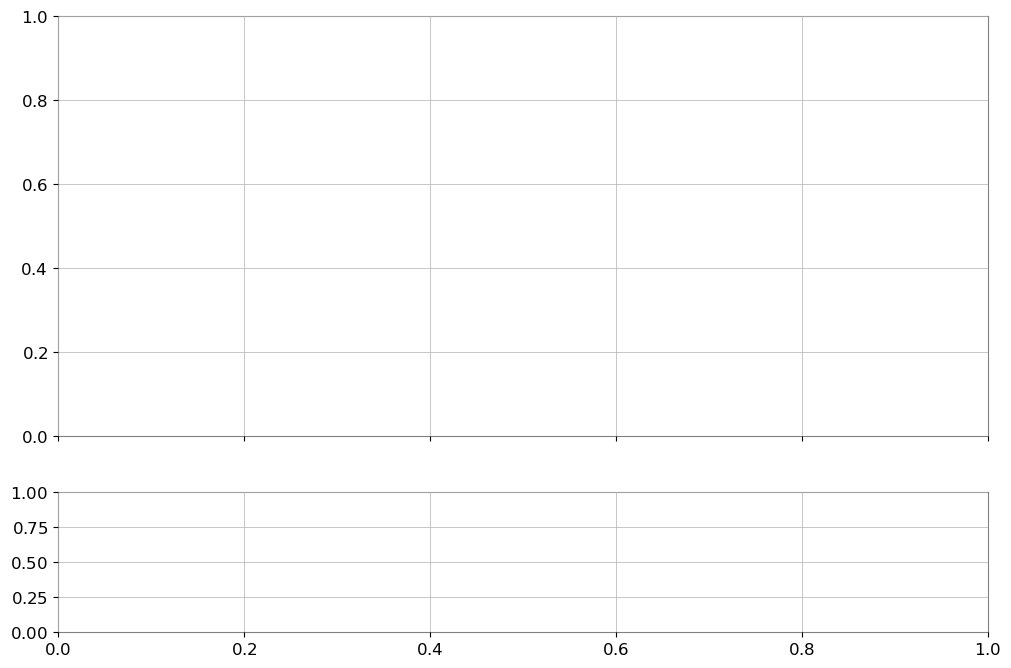

In [18]:
# Visualize fit results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]})

# 1. Data and fit
ax1 = axes[0]

# Data with error bars (from diagonal of covariance)
diag_err = np.sqrt(np.maximum(np.diag(cov_fit.value), 0))
ax1.errorbar(
    freq_vals, psd_fit.value, yerr=diag_err,
    fmt="o", markersize=3, alpha=0.6, label="Data", capsize=2,
)

# Best-fit model
f_model = np.linspace(freq_min, freq_max, 500)
y_model = psd_model(f_model, **params_gls)
ax1.plot(f_model, y_model, "r-", linewidth=2, label="GLS Fit")

# True model for comparison
y_true = psd_model(f_model, **true_params)
ax1.plot(f_model, y_true, "g--", linewidth=1.5, alpha=0.7, label="True Model")

ax1.set_yscale("log")
ax1.set_ylabel("PSD [1/Hz]")
ax1.set_title("GLS Fit: Power-Law Background + Lorentzian Peak")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Normalized residuals
ax2 = axes[1]
y_fit_at_data = psd_model(freq_vals, **params_gls)
residuals = (psd_fit.value - y_fit_at_data) / diag_err
ax2.scatter(freq_vals, residuals, s=10, alpha=0.7)
ax2.axhline(0, color="r", linestyle="-", linewidth=1)
ax2.axhline(2, color="gray", linestyle="--", alpha=0.5)
ax2.axhline(-2, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Residual / σ")
ax2.set_ylim(-4, 4)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. MCMC Uncertainty Evaluation

MCMC (Markov Chain Monte Carlo) provides a more robust estimation of parameter uncertainties and correlations.

### 5.1 Run MCMC

In [19]:
# MCMC parameters
n_walkers = 32
n_steps = 3000
burn_in = 500

print(f"Running MCMC with {n_walkers} walkers, {n_steps} steps...")
print(f"Burn-in: {burn_in} steps")

try:
    sampler = result_gls.run_mcmc(
        n_walkers=n_walkers,
        n_steps=n_steps,
        burn_in=burn_in,
        progress=True,
    )
    mcmc_available = True
except ImportError as e:
    print(f"MCMC requires 'emcee' package: {e}")
    mcmc_available = False
except Exception as e:
    print(f"MCMC error: {e}")
    mcmc_available = False

Running MCMC with 32 walkers, 3000 steps...
Burn-in: 500 steps
MCMC error: name 'result_gls' is not defined


### 5.2 Convergence Diagnostics

In [20]:
if mcmc_available:
    # Acceptance fraction
    acc_frac = np.mean(sampler.acceptance_fraction)
    print(f"\nMCMC Diagnostics:")
    print(f"  Mean acceptance fraction: {acc_frac:.3f}")
    print(f"  (Optimal range: 0.2 - 0.5)")
    
    # Autocorrelation time (if enough samples)
    try:
        tau = sampler.get_autocorr_time(quiet=True)
        print(f"\n  Autocorrelation times:")
        for i, name in enumerate(params_gls.keys()):
            print(f"    {name}: {tau[i]:.1f} steps")
        print(f"  Effective samples: ~{n_steps / np.max(tau):.0f}")
    except Exception:
        print("  (Autocorrelation time estimation requires more samples)")

### 5.3 Corner Plot and Trace Plots

In [21]:
if mcmc_available:
    # Corner plot
    try:
        result_gls.plot_corner(
            truths=list(true_params.values()),
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
        )
        plt.suptitle("MCMC Posterior Distributions (GLS)", y=1.02)
        plt.show()
    except ImportError:
        print("Corner plot requires 'corner' package")

In [22]:
if mcmc_available:
    # Trace plots
    samples = sampler.get_chain()  # Shape: (n_steps, n_walkers, n_params)
    param_names = list(params_gls.keys())
    
    fig, axes = plt.subplots(len(param_names), 1, figsize=(12, 2.5 * len(param_names)), sharex=True)
    
    for i, (ax, name) in enumerate(zip(axes, param_names)):
        for j in range(min(10, n_walkers)):  # Plot subset of walkers
            ax.plot(samples[:, j, i], alpha=0.3, linewidth=0.5)
        ax.axhline(true_params[name], color="r", linestyle="--", label="True")
        ax.axvline(burn_in, color="gray", linestyle=":", alpha=0.5, label="Burn-in")
        ax.set_ylabel(name)
        if i == 0:
            ax.legend(loc="upper right")
    
    axes[-1].set_xlabel("Step")
    plt.suptitle("MCMC Trace Plots", y=1.01)
    plt.tight_layout()
    plt.show()

## 6. GLS vs OLS Comparison

### 6.1 Run OLS Fit (Diagonal Covariance Only)

OLS (Ordinary Least Squares) ignores off-diagonal correlations, using only the diagonal variances.

In [23]:
# Create diagonal-only covariance (for OLS)
diag_variances = np.diag(cov_fit.value)
cov_diag_matrix = np.diag(diag_variances)

cov_ols = BifrequencyMap.from_points(
    cov_diag_matrix,
    f2=cov_fit.frequency2,
    f1=cov_fit.frequency1,
    unit=cov_fit.unit,
    name="Diagonal Covariance (OLS)",
)

# OLS fit
result_ols = fit_series(
    psd_fit,
    psd_model,
    cov=cov_ols,
    p0=p0,
    limits=bounds,
)

print("OLS Fit Results:")
print("=" * 50)
display(result_ols)

NameError: name 'cov_fit' is not defined

### 6.2 Compare GLS and OLS Results

In [24]:
params_ols = result_ols.params
errors_ols = result_ols.errors

print("\nGLS vs OLS Comparison:")
print("=" * 85)
print(f"{'Parameter':<10} {'GLS Value':<14} {'GLS Error':<12} {'OLS Value':<14} {'OLS Error':<12} {'Ratio':>8}")
print("-" * 85)

error_ratios = []
for name in params_gls.keys():
    gls_val = params_gls[name]
    gls_err = errors_gls[name]
    ols_val = params_ols[name]
    ols_err = errors_ols[name]
    ratio = gls_err / ols_err if ols_err > 0 else float('inf')
    error_ratios.append((name, ratio))
    
    if abs(gls_val) < 0.01:
        print(f"{name:<10} {gls_val:<14.3e} {gls_err:<12.3e} {ols_val:<14.3e} {ols_err:<12.3e} {ratio:>8.2f}")
    else:
        print(f"{name:<10} {gls_val:<14.4f} {gls_err:<12.4f} {ols_val:<14.4f} {ols_err:<12.4f} {ratio:>8.2f}")

print("-" * 85)
print(f"\nχ²/ndof:  GLS = {result_gls.reduced_chi2:.3f}    OLS = {result_ols.reduced_chi2:.3f}")

NameError: name 'result_ols' is not defined

NameError: name 'error_ratios' is not defined

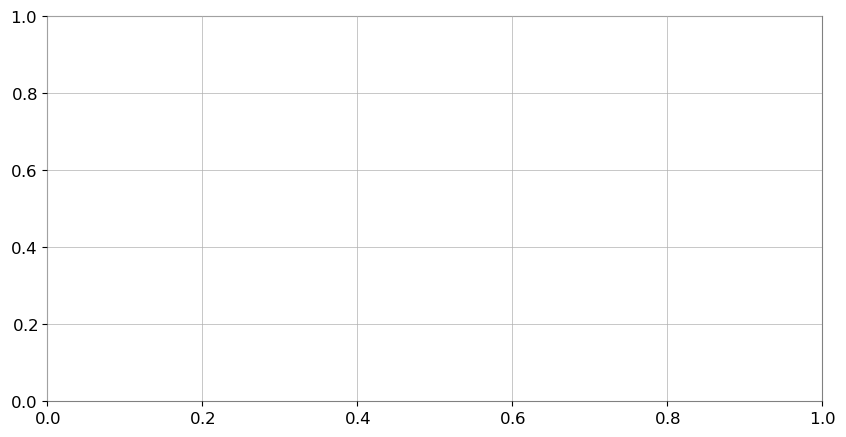

In [25]:
# Visualize error ratio comparison
fig, ax = plt.subplots(figsize=(10, 5))

names = [r[0] for r in error_ratios]
ratios = [r[1] for r in error_ratios]

x = np.arange(len(names))
bars = ax.bar(x, ratios, color="steelblue", edgecolor="black")

# Add reference line at ratio=1
ax.axhline(1.0, color="r", linestyle="--", linewidth=2, label="Ratio = 1 (Equal)")

ax.set_xlabel("Parameter")
ax.set_ylabel("Error Ratio (GLS / OLS)")
ax.set_title("Parameter Uncertainty: GLS vs OLS")
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Annotate bars
for bar, ratio in zip(bars, ratios):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{ratio:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

### 6.3 Key Insights

**GLS errors are typically larger than OLS errors** because:

1. **OLS underestimates uncertainties** by ignoring positive correlations between adjacent bins
2. **GLS properly accounts** for the reduced effective degrees of freedom
3. The error ratio (GLS/OLS > 1) reflects the **true impact of correlations**

**Expected with ~0.25 correlation**: GLS errors 10-30% larger than OLS

**Why GLS differs from OLS**:
1. OLS assumes independence → underestimates uncertainties
2. GLS accounts for correlation → reduces effective degrees of freedom
3. Error ratio (GLS/OLS) quantifies correlation impact
4. With 50% overlap: ~0.25 correlation leads to meaningful GLS vs OLS differences

**Practical implications:**
- OLS may produce overconfident (too small) error bars
- GLS provides more honest uncertainty estimates
- For precision measurements, GLS is essential


## 7. Summary and Best Practices

### Key Takeaways

1. **Bootstrap PSD estimation** provides both the spectrum and its full covariance matrix
2. **Overlapping segments** introduce correlations that standard methods ignore
3. **GLS fitting** properly weights data according to the covariance structure
4. **MCMC** provides robust posterior distributions for complex models
5. **OLS underestimates errors** when correlations are present

### Recommended Workflow

```python
# 1. Generate spectrogram
stride = fftlength - overlap
spectrogram = data.spectrogram(stride=stride, fftlength=fftlength, overlap=overlap, window='hann')

# 2. Bootstrap with covariance
psd, cov = bootstrap_spectrogram(spectrogram, return_map=True, ...)

# 3. GLS fit
result = fit_series(psd, model, cov=cov, p0=..., limits=...)

# 4. MCMC for robust uncertainties
result.run_mcmc(n_walkers=32, n_steps=5000)
result.plot_corner()
```

### Common Pitfalls

- **Using OLS for correlated data** → underestimated errors
- **Too few bootstrap samples** → noisy covariance estimate
- **Poor initial guesses** → fit may converge to local minimum
- **Forgetting to crop covariance** → dimension mismatch errors

## Appendix: BifrequencyMap Operations

Quick reference for common `BifrequencyMap` operations.

In [26]:
# Example BifrequencyMap operations

# 1. Get inverse (for manual GLS)
cov_inv = cov_fit.inverse()
print(f"Inverse shape: {cov_inv.shape}")
print(f"Inverse unit: {cov_inv.unit}")

# 2. Extract diagonal (variances)
variances = np.diag(cov_fit.value)
std_devs = np.sqrt(np.maximum(variances, 0))
print(f"\nDiagonal extracted: {len(variances)} values")

# 3. Compute correlation matrix
std_outer = np.outer(std_devs, std_devs)
std_outer[std_outer == 0] = 1
correlation = cov_fit.value / std_outer
print(f"Correlation range: [{correlation.min():.3f}, {correlation.max():.3f}]")

# 4. Create from scratch
n = 10
test_cov = np.eye(n) + 0.1 * np.ones((n, n))  # Diagonal + small off-diagonal
test_freqs = np.arange(n) * 1.0 + 50.0
test_map = BifrequencyMap.from_points(
    test_cov,
    f2=test_freqs,
    f1=test_freqs,
    unit="Hz^-2",
    name="Test Covariance",
)
print(f"\nCreated test BifrequencyMap: {test_map.shape}")

NameError: name 'cov_fit' is not defined

---

## Further Reading

- **Percival & Walden (1993)**: Spectral Analysis for Physical Applications - VIF derivation
- **gwexpy API**: [Spectral module](../../reference/api/spectral.rst), [Fitting module](../../reference/api/fitting.rst)
- **Related tutorials**: [Advanced Fitting](advanced_fitting.ipynb), [Noise Budget](../examples/case_noise_budget.ipynb)